<a href="https://colab.research.google.com/github/slothfulz/Pair-Trading-Backtester/blob/main/Cointegration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cointegration**
This is the process of identifying stocks that are related by mean reversion. Mean reversion is the idea that there is an average that most stocks rest.

In [ ]:
import pandas as pd #data analysis and manipulation
import yfinance as yf
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import requests
import matplotlib.pyplot as plt


In [ ]:
header = {"User-Agent": "CointegrationMR/0.1(contact:tforgah@usc.edu)"}


In [ ]:
tickers = pd.read_html ("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies", storage_options = header)[0].Symbol.to_list()


In [ ]:
df = yf.download(tickers, start = '2024-01-01')['Close']



/tmp/ipython-input-668283513.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start = '2024-01-01')['Close']
[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-01-01 -> 2026-01-11)')


In [ ]:
df.columns

combination= pd.DataFrame(combinations(df.columns,2))


In [ ]:
combination.columns = ['1st_stock', '2nd_stock']

In [ ]:
corr = df.corr()

combination['correlation'] = combination.apply(
    lambda row:np.corrcoef(df[row['1st_stock']], df[row['2nd_stock']])[0,1],axis=1

)

Filtering for highly correlated stock pairs from 2023

In [ ]:
combination = combination[combination.correlation > 0.95]
combination

,1st_stock,2nd_stock,correlation
5988,AEE,ATO,0.976435
6044,AEE,CMS,0.963492
6081,AEE,DGX,0.962816
6092,AEE,DTE,0.958985
6117,AEE,ETR,0.986778
...,...,...,...
124222,TKO,WMT,0.961099
125883,VTR,WELL,0.965198
126001,WBD,WDC,0.953314
126074,WEC,XEL,0.954127


ADF test to check relatively

stationary pairs (check if relationship between two stocks are infinite)

In [ ]:
def do_reg(stock1, stock2):
  x=df[stock1].values
  y=df[stock2].values
  X= sm.add_constant(x)
  model = sm.OLS(y,X).fit()
  alpha,beta = model.params
  residuals = y-(alpha + beta * X[:,1])
  if np.isnan(residuals).any():
    return np.nan

  adf_result = adfuller(residuals)
  return adf_result[0], adf_result[1], beta, alpha



In [ ]:
combination[['adf_stat','p_value', 'beta','alpha']] = combination.apply(lambda row:   pd.Series(do_reg(row['1st_stock'], row['2nd_stock'])), axis = 1)

In [ ]:
combination[combination.p_value<0.01].sort_values(by = 'adf_stat')

,1st_stock,2nd_stock,correlation,adf_stat,p_value,beta,alpha
59102,DGX,DTE,0.957343,-5.354994,0.000004,0.607873,25.561988
78652,FOX,WMT,0.966693,-5.090261,0.000015,1.571165,16.394081
72232,EVRG,TKO,0.957459,-5.074707,0.000016,3.896780,-97.565448
59287,DGX,NI,0.970515,-5.011988,0.000021,0.301307,-12.392617
104098,LYV,MA,0.954515,-4.864253,0.000041,1.970630,269.440801
...,...,...,...,...,...,...,...
59127,DGX,ETR,0.958889,-3.455364,0.009210,0.795813,-53.128515
98012,KEY,USB,0.965412,-3.449394,0.009386,2.013514,11.222189
100417,L,MS,0.957009,-3.447908,0.009430,2.734311,-113.457084
91427,IBKR,RL,0.965994,-3.444054,0.009546,4.140148,46.939404


In [ ]:
spread = df['DGX']-(25.561988 -0.607873 * df['DTE'])

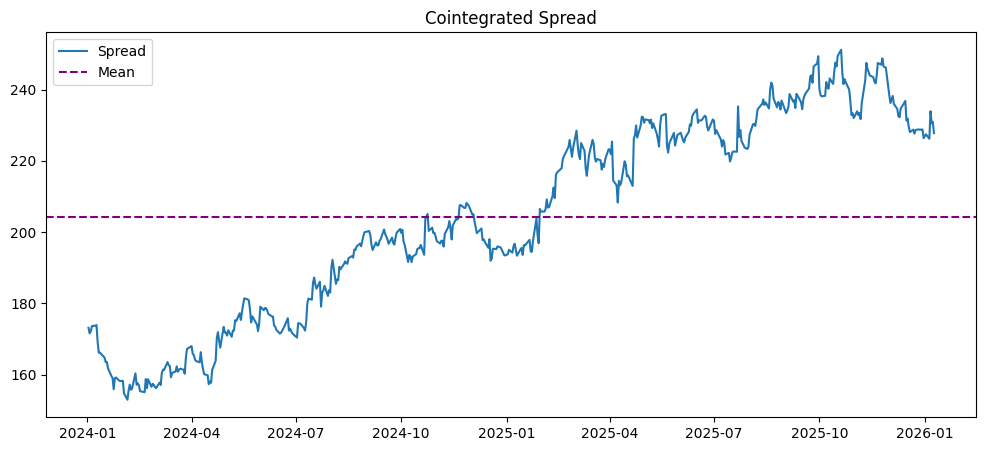

In [ ]:
plt.figure(figsize = (12,5))
plt.plot(spread, label ="Spread")
plt.axhline(spread.mean(), color = 'purple', linestyle = '--', label = "Mean")
plt.legend()
plt.title ("Cointegrated Spread")
plt.show()
